# Notebook for project results in 02456 Deep Learning
This notebook will load our final model and will perform inference on 6 randomly selected clean-noise pairs from the test set.

Firstly, the model and audio files will be downloaded from Google Drive. Note that these will be stored locally in the folder "notebook_files".

In [16]:
import torch
from models.autoencoder_without_PQC.AudioDec import Generator as GeneratorAudioDec
from models.autoencoder.AudioDec import Generator as generator_audiodec_original
from models.vocoder.HiFiGAN import Generator as generator_hifigan
import torchaudio
import glob
from dataloader.data_utils import add_noise
import os
# from bin.utils import load_config
import yaml

directory = "notebook_files\\"

## Loading the model


In [17]:
def load_config(path_to_config):
    with open(path_to_config, "r") as f:
        config = yaml.load(f, Loader=yaml.FullLoader)

    return config

def define_AD_model(directory):
    path_to_config_encoder = os.path.join(
        directory, "config", "denoise", "symAD_vctk_48000_hop300.yaml"
    )
    path_to_model_encoder = os.path.join(directory, "audiodec_encoder.pkl")
    encoder_config = load_config(path_to_config_encoder)
    encoder = generator_audiodec_original(**encoder_config["generator_params"])
    encoder.load_state_dict(
        torch.load(path_to_model_encoder, map_location="cpu")["model"]["generator"]
    )
    # Decoder
    path_to_config_decoder = os.path.join(
        directory, "config", "vocoder", "AudioDec_v1_symAD_vctk_48000_hop300_clean.yaml"
    )
    path_to_model_decoder = os.path.join(directory, "audiodec_vocoder.pkl")
    decoder_config = load_config(path_to_config_decoder)
    decoder = generator_hifigan(**decoder_config["generator_params"])
    decoder.load_state_dict(
        torch.load(path_to_model_decoder, map_location="cpu")["model"]["generator"]
    )

    def forward(x):
        x = encoder.encoder(x)
        x = encoder.projector(x)
        x, _, _ = encoder.quantizer(x)
        return decoder(x)

    return forward

config = {
    "input_channels": 1,
    "output_channels": 1,
    "encode_channels": 32,
    "decode_channels": 32,
    "bias": True,
    "enc_ratios": [2, 4, 8, 16],
    "dec_ratios": [16, 8, 4, 2],
    "enc_strides": [3, 4, 5, 5],
    "dec_strides": [5, 5, 4, 3],
    "mode": 'causal'
}

model: dict[str, torch.nn.Module] = {}
model["generator"] = GeneratorAudioDec(**config)
state_dict = torch.load(directory+"model.pkl", map_location="cpu")
model["generator"].load_state_dict(state_dict)
AD_model = define_AD_model(directory)

SAMPLE_RATE = 24000


## Load data


In [18]:
def get_file_paths(prefix):
    return glob.glob(directory+prefix+"*"+".wav")
clean_file_paths = get_file_paths("clean")
noise_file_paths = get_file_paths("noise")

def load_samples(file_paths):
    samples = []
    for file_path in file_paths:
        audio, original_sample_rate = torchaudio.load(file_path)
        # Down sample to fit trained model
        audio = torchaudio.functional.resample(audio, original_sample_rate, SAMPLE_RATE)
        samples.append(audio)
    return  samples


clean_samples = load_samples(clean_file_paths)
noise_samples = load_samples(noise_file_paths)

for i, (clean_sample,noise_sample) in enumerate(zip(clean_samples,noise_samples)):
    if clean_sample.shape[1] > noise_sample.shape[1]:
        clean_samples[i] = clean_sample[:, :noise_sample.shape[1]]
    else:
        noise_samples[i] = noise_sample[:, :clean_sample.shape[1]]


# Storing trimmed noise files
for i, noise_sample in enumerate(noise_samples):
    # (C,L) -> (B,C,L)
    file_path = directory+f"noise{i+1}.wav"
    torchaudio.save(file_path,noise_sample,SAMPLE_RATE)
    noise_file_paths[i]=file_path

# Mixing at SNR of 15
mixed_samples = [add_noise(speech,noise,torch.tensor(15)) for speech,noise in zip(clean_samples,noise_samples)]



## Inference

In [19]:
predictions = []
predictions_AD = []
pred_file_paths = []
pred_AD_file_paths = []
mixed_file_paths = []
with torch.no_grad():
    for i, mixed_sample in enumerate(mixed_samples):
        print(f"Sample {i}")
        # (C,L) -> (B,C,L)
        file_path = directory+f"mixed{i+1}.wav"
        torchaudio.save(file_path,mixed_sample,SAMPLE_RATE)
        mixed_file_paths.append(file_path)
    
    
        mixed_sample = mixed_sample.unsqueeze(0)
        pred = model["generator"](mixed_sample)
        pred = pred.squeeze(0).detach()
        
        pred_AD = torch.squeeze(AD_model(mixed_sample), dim=0)
    
        predictions.append(pred)
        predictions_AD.append(pred_AD)
        
        file_path = directory+f"prediction{i+1}.wav"
        torchaudio.save(file_path,pred,SAMPLE_RATE)
        pred_file_paths.append(file_path)
        
        file_path = directory+f"prediction{i+1}_AD.wav"
        torchaudio.save(file_path, pred_AD, SAMPLE_RATE)
        pred_AD_file_paths.append(file_path)

Sample 0
Sample 1
Sample 2
Sample 3
Sample 4
Sample 5


## Showcase


In [20]:
import IPython,time
from IPython.display import Audio, HTML, Markdown, display


def html_label_audio(audio_path):
    # print(audio_path)
    sep = "notebook_files\\"
    return f"""
    <div>
        <p>{audio_path.split(sep)[1]}</p>
        <audio controls>
            <source src="{audio_path}" type="audio/wav">
        </audio>
    </div>
    """

def html_wrap_cells(cells):
    connector = "\n"
    return f"""
    <h2>Experiment</h2>
    <h4>Input</h4>
    <div style="display: flex;flex:50%; align-items: center; justify-content: space-around;">
        {cells[0]}
        {cells[1]}
    </div>
    <h4>Inference</h4>
    <div style="display: flex;flex:50%; align-items: center; justify-content: space-around;">
        {cells[2]}
    </div>
    <div style="display: flex;flex:50%; align-items: center; justify-content: space-around;">
        <b>Proposed</b>{cells[3]}
        <b>AudioDec</b>{cells[4]}
    </div>
    """

for i, sample in enumerate(clean_samples):
    clean_html = html_label_audio(clean_file_paths[i])
    noise_html = html_label_audio(noise_file_paths[i])
    mixed_html = html_label_audio(mixed_file_paths[i])
    pred_html = html_label_audio(pred_file_paths[i])
    pred_AD_html = html_label_audio(pred_AD_file_paths[i])

    display(HTML(data=html_wrap_cells([clean_html,noise_html,mixed_html,pred_html,pred_AD_html])))
    time.sleep(1)


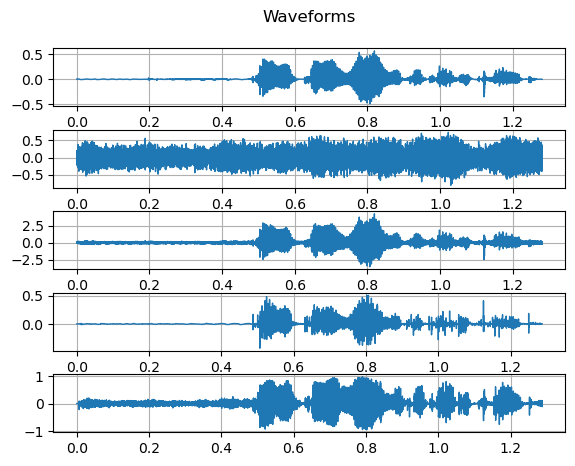

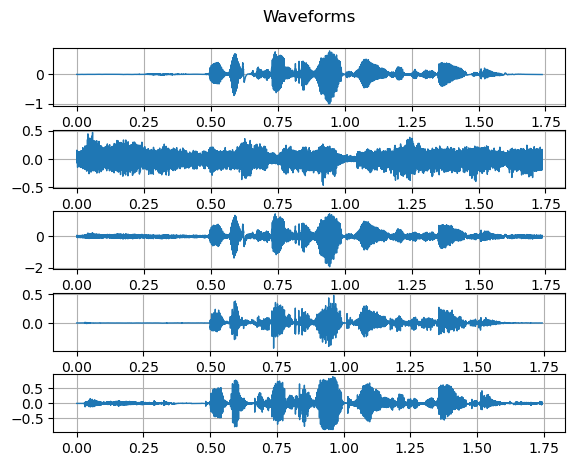

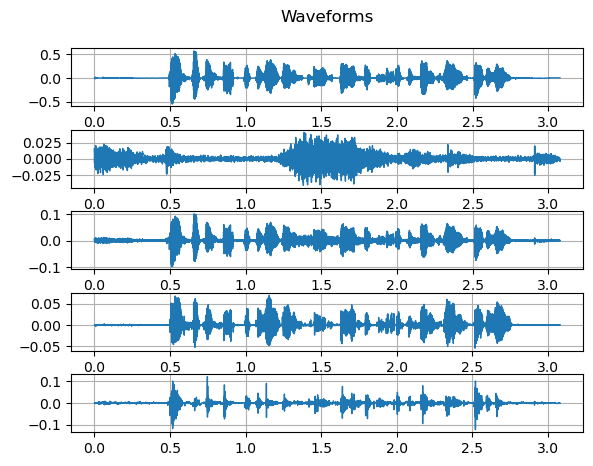

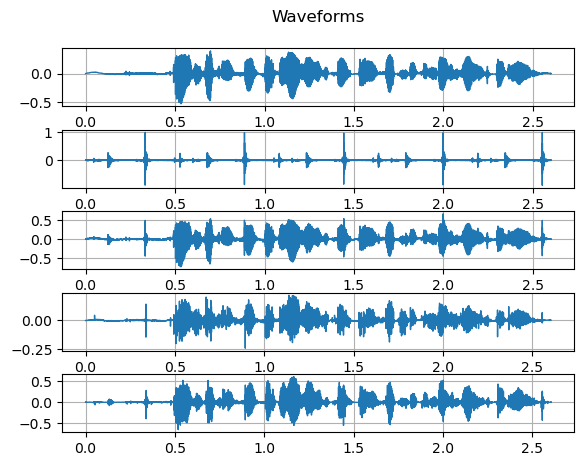

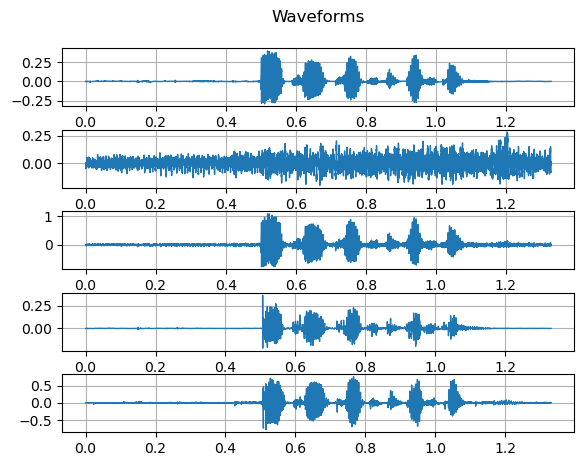

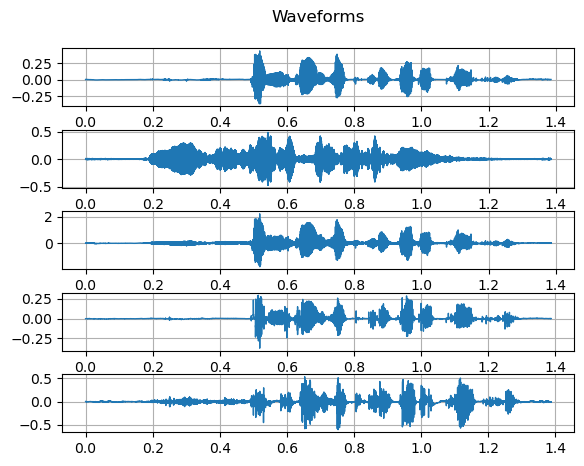

In [24]:
import matplotlib.pyplot as plt
def plot_waveform(waveforms, sample_rate, title="Waveform", xlim=None, ylim=None):
    figure, axes = plt.subplots(len(waveforms), 1)

    for c, waveform in enumerate(waveforms):
        waveform = waveform.numpy()

        num_channels, num_frames = waveform.shape
        time_axis = torch.arange(0, num_frames) / sample_rate
        axes[c].plot(time_axis, waveform[0], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c + 1}')
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
        figure.suptitle(title)
    plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
    plt.show(block=False)


i_sample = 0
for i in range(len(clean_samples)):
    plot_waveform([clean_samples[i], noise_samples[i], mixed_samples[i], predictions[i],predictions_AD[i]], 48000, f"Waveforms for sample pair {i}")
